# Исследование данных о продажах автомобилей для предсказания их цены

Описание получения данных:

  - Данные были взяты из открытой сети с сайта https://drom.ru. В отличие от остальных площадок, здесь нет защиты от ботов и прочего автоматизированного сбора данных. К сожалению алгоритм работает около 900-1000 секунд. Это не большая проблема, для создания распараллеливания понадобилось бы больше времени, так что это не оправдано, данные собираем всего один раз.\
  Но были некоторые ограничения:
    * По одной ветке фильтрования сайт может выдать лишь 100 страниц, это около 2,000 карточек машин. 
    * Один класс объекта span для характеристик.

  Так что для простоты было принято решение на каждой итерации обращаться к ссылке по одному довольно густо населённому городу с радиусом поиска + 500 км к границам города. Так мы точно получим не менее 2,000 карточек. 

  Поиск производился по 20 совершенно случайным густонаселённым городам. Так что будем считать, что для России данная выборка достаточно репрезентативна.

  Данные брались бывшим в употреблении машинам абсолютно разных классов.

Описание исследования:

  - Так как данные взяты о б/у автомобилях, то цель исследования - выявить алгоритм, позволяющий предсказать цену автомобиля в зависимости от всех его характеристик.\
  Данный алгоритм будет полезен при размешении автомобиля на сайте, чтобы дать адекватную оценку по рынку



# Импорты

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.stats as stats
from copy import deepcopy
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

rst=45
sns.set(font_scale=0.8)

# Обзор датасета

In [2]:
df = pd.read_csv('parsed_drom_ru.csv').drop(columns=['Unnamed: 0'])
df

,make,model,year,engine_capacity,power,fuel_type,transmission,drive_mode,price,mileage
0,Mitsubishi,Outlander,2021,2.5,181,бензин,вариатор,4WD,3000000,12
1,Toyota,C-HR,2022,1.8,98,гибрид,вариатор,передний,2520000,4
2,Daewoo,Nexia,2010,1.5,80,бензин,механика,передний,190000,293
3,Volkswagen,Tiguan,2011,1.4,150,бензин,механика,4WD,1150000,121
4,Mercedes-Benz,G-Class,2020,2.9,249,дизель,АКПП,4WD,14970000,47
...,...,...,...,...,...,...,...,...,...,...
38876,Daihatsu,Move,2016,0.7,52,бензин,вариатор,передний,535000,138
38877,Toyota,Allion,2006,1.5,109,бензин,АКПП,передний,620000,189
38878,Toyota,Ipsum,2004,2.4,160,бензин,АКПП,4WD,850000,205
38879,Toyota,Vitz,2009,1.3,87,бензин,вариатор,передний,490000,186


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38881 entries, 0 to 38880
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   make             38881 non-null  object 
 1   model            38881 non-null  object 
 2   year             38881 non-null  int64  
 3   engine_capacity  38881 non-null  float64
 4   power            38881 non-null  int64  
 5   fuel_type        38881 non-null  object 
 6   transmission     38881 non-null  object 
 7   drive_mode       38881 non-null  object 
 8   price            38881 non-null  int64  
 9   mileage          38881 non-null  int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 3.0+ MB


Датасет с 38780 записями и 9 столбцами. \
Опишем столбцы:

- `make` - производитель            
- `model` - модель         
- `year` - год производства          
- `engine_capacity` - объём двигателя 
- `power` - мощьность двигателя     
- `fuel_type` - тип топлива         
- `transmission` - тип коробки передач     
- `drive_mode` - привод машины     
- `price` - цена     
- `mileage` - пробег


# Исследуем переменные

## Проверим пропуски

In [4]:
df.isna().sum()

make               0
model              0
year               0
engine_capacity    0
power              0
fuel_type          0
transmission       0
drive_mode         0
price              0
mileage            0
dtype: int64

## Производитель

Выведем уникальные значения и визуально оценим нет ли в них похожих марок, которые просто по-разному записаны

In [5]:
pd.Series(df.make.unique()).sort_values()

20             Audi
13              BMW
6           Changan
30            Chery
16        Chevrolet
32          Citroen
2            Daewoo
17         Daihatsu
24             Ford
22            Geely
33            Haval
14            Honda
5           Hyundai
34         Infiniti
10              Kia
15             Land
7             Lexus
25            Lifan
18             MINI
27            Mazda
4     Mercedes-Benz
0        Mitsubishi
11           Nissan
23             Opel
9           Peugeot
29            Ravon
26          Renault
21            Skoda
8         SsangYong
19           Subaru
1            Toyota
3        Volkswagen
28            Volvo
35              ЗАЗ
12             Лада
31              УАЗ
dtype: object

## Модель

При OneHotEncoding это поле будет лишним, слишком тяжёлая модель получится.\
Так что уберём его

In [6]:
df = df.drop(columns=['model'])

Здесь также не наблюдается аномалий

## Год

In [7]:
def graph(column):
    dataG = df[df[column] > 0]
    fig = plt.figure()
    gs = gridspec.GridSpec(2, 2)

    fig.set_figheight(10)
    fig.set_figwidth(15)

    sns.violinplot(x=dataG[column], ax=plt.subplot(gs[0, 0:]))
    stats.probplot(dataG[column], dist="norm", plot=plt.subplot(gs[1, 0]))
    
    sns.histplot(x=dataG[column], kde=True, ax=plt.subplot(gs[1, 1]))

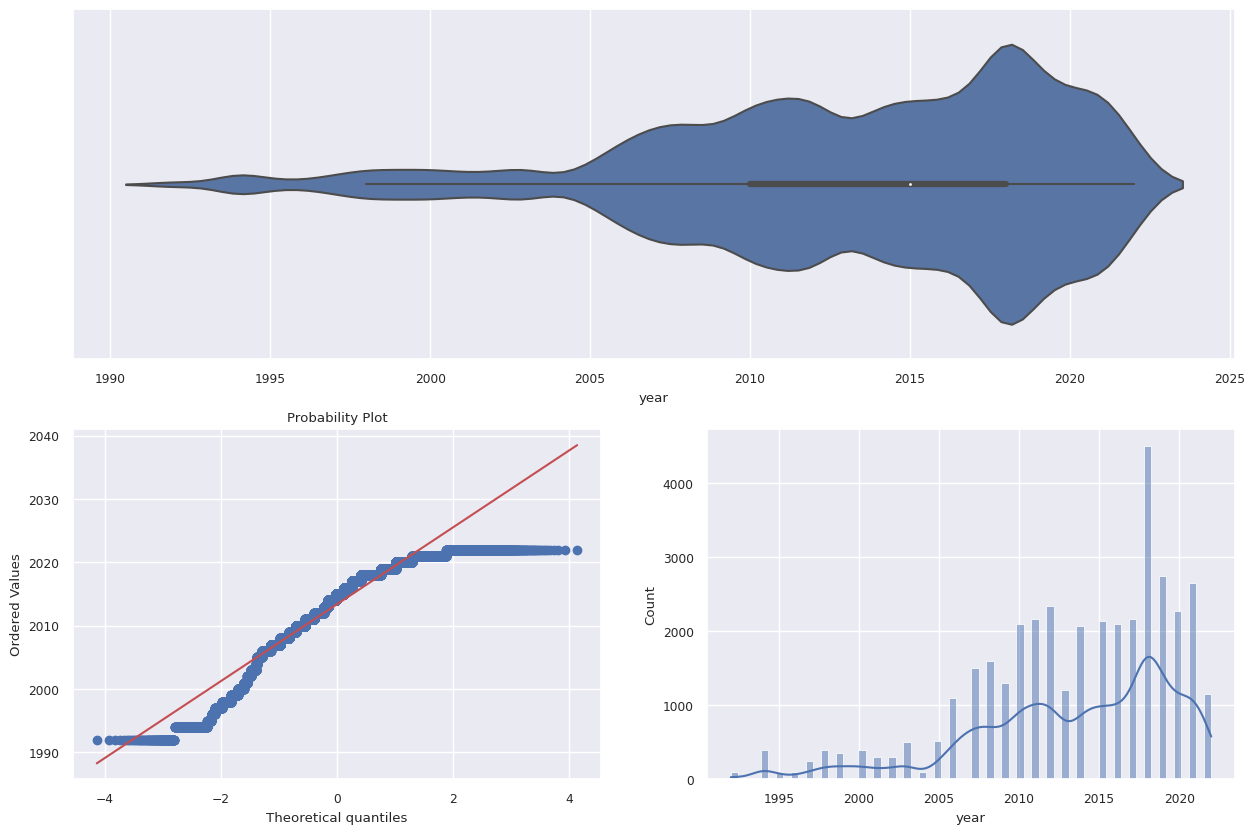

In [8]:
graph('year')

Видим что-то похожее на дискретное распределение, судя по гистограмме, однако на квантиль-квантиль графике видно, что не всё так прохо, такие данные для модели будут полезны, здесь дату не нужно преобразовывать, мы лишь нормализуем её.

По ящику с усами можно увидеть, что в нашей выборке сосредоточены в основном новые автомобили. Хотя довольно старые от 13 до 7 лет занимают немалую часть

## Объём двигателя

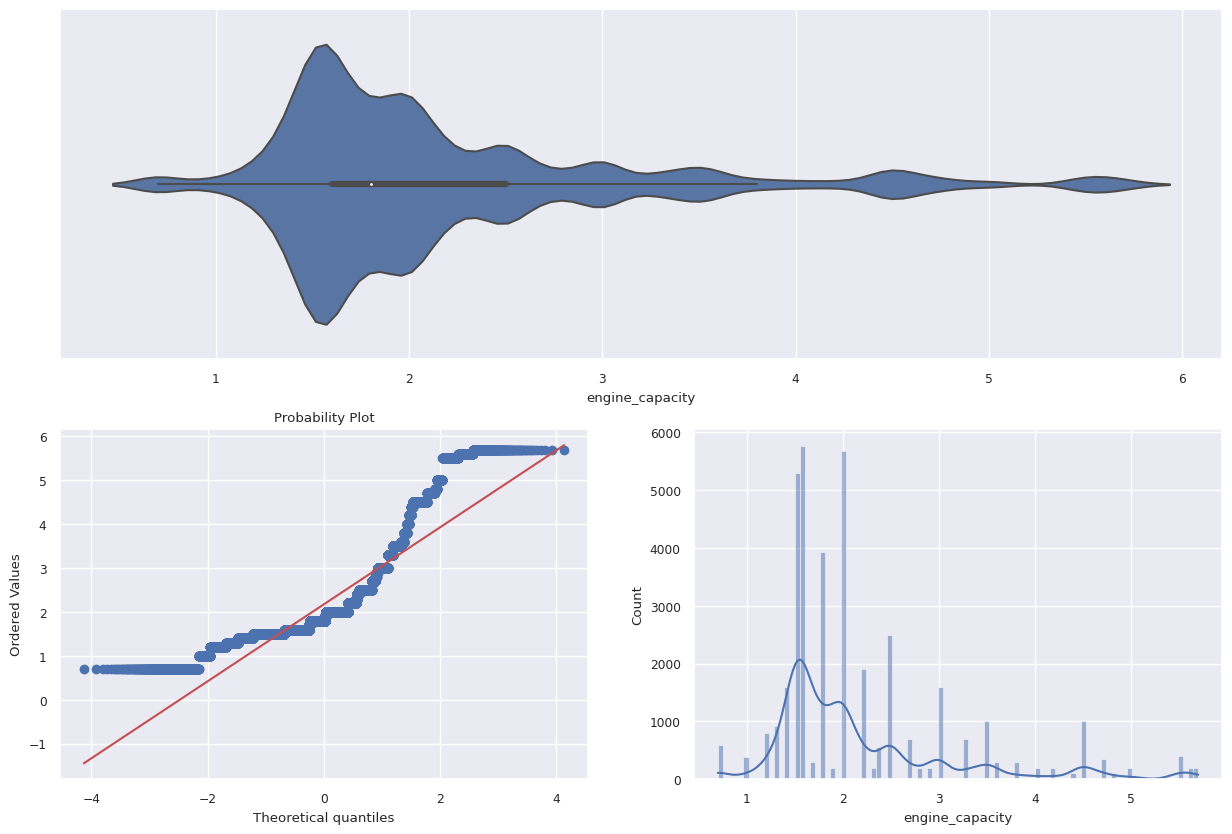

In [9]:
graph('engine_capacity')

Так как двигатели делаются по определённому стандарту, значения будут не очень вариативны. Другими словами как на гистограмме, так и на квантиль-квантиль графике видно дискретное распределение. 

Основная доля двигателей объёмом от 1.5 до 2.3 литров

## Мощность

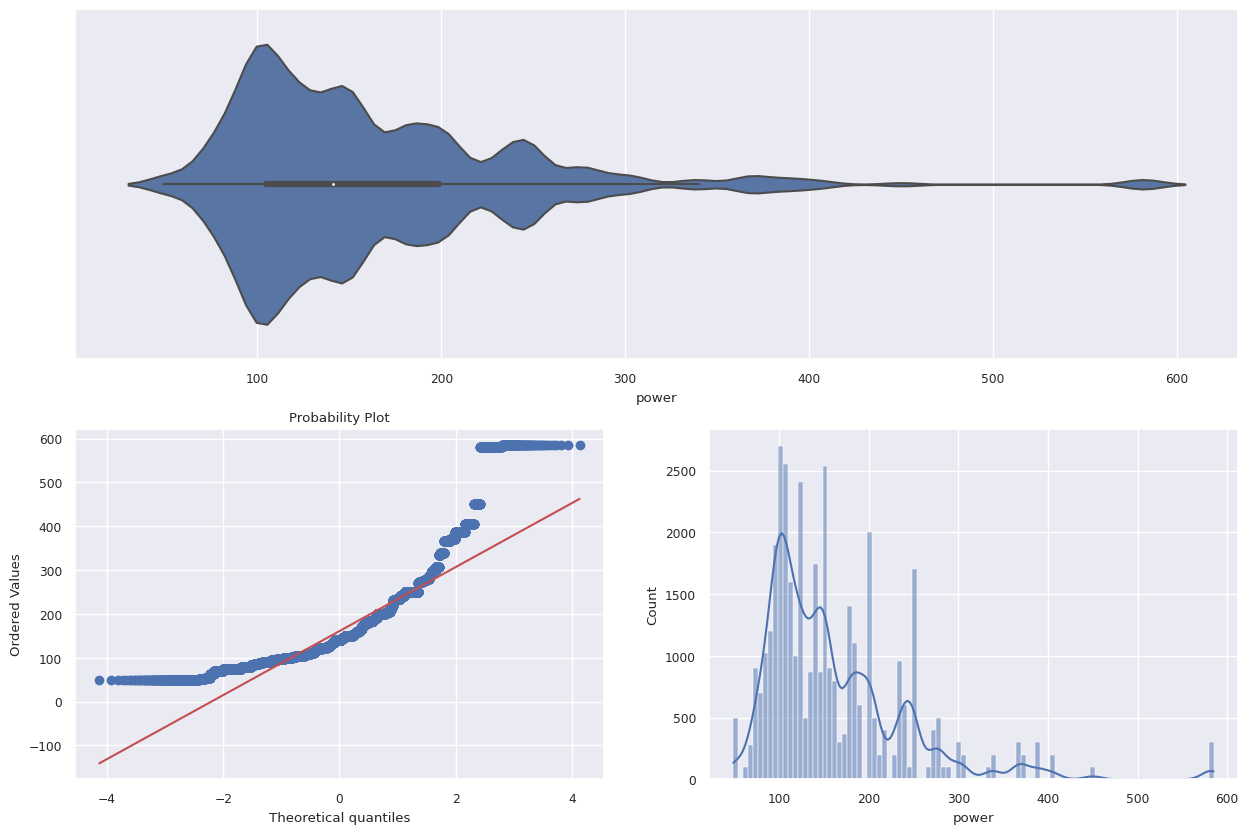

In [10]:
graph('power')

Наблюдаем экспоненциальное распределение. Его просто нормализируем, так модель будет явно лучше работать. Машины мощьностью более 500 л.с. стоит исключить

Основная масса данных эта машины мощностью от 100 до 200 л.с.

In [11]:
df = deepcopy(df[df.power < 500])

## Тип топлива

In [12]:
df.fuel_type.unique()

array(['бензин', 'гибрид', 'дизель', 'электро'], dtype=object)

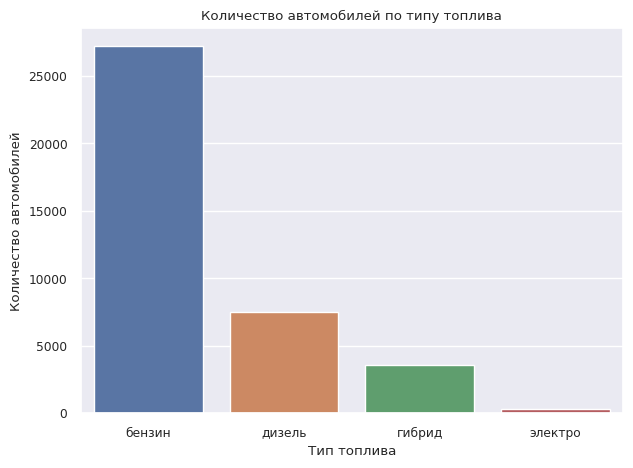

In [13]:
fig = plt.figure(figsize=(7, 5))

sns.barplot(data=df.fuel_type.value_counts().reset_index(), x='index', y='fuel_type')
plt.title('Количество автомобилей по типу топлива')
plt.xlabel('Тип топлива')
plt.ylabel('Количество автомобилей')
pass

Как можем заметить бензин лидирует, дизельные автомобили оказывается продаются практически в таком же количестве как и гибридные, интересное наблюдение.

## Коробка передач

In [14]:
df.transmission.unique()

array(['вариатор', 'механика', 'АКПП', 'робот', 'автомат'], dtype=object)

Интересная особенность Автоматическую коробку переключения передач называют "АКПП" и "автомат" исправим всё на "автомат", чтобы классы были в одном стиле

In [15]:
df['transmission'] = df.transmission.apply(lambda x: 'автомат' if x == 'АКПП' else x)

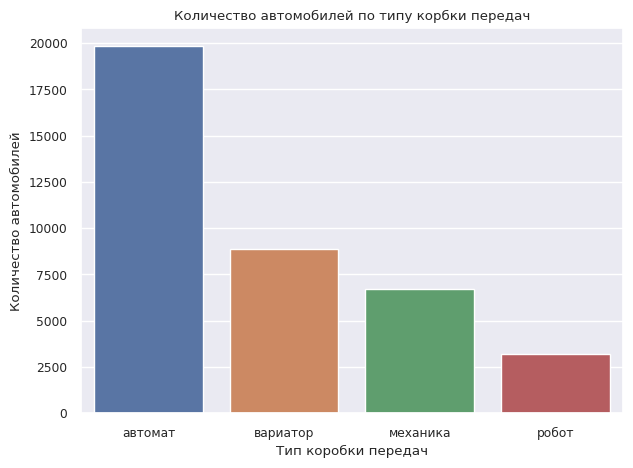

In [16]:
fig = plt.figure(figsize=(7, 5))

sns.barplot(data=df.transmission.value_counts().reset_index(), x='index', y='transmission')
plt.title('Количество автомобилей по типу корбки передач')
plt.xlabel('Тип коробки передач')
plt.ylabel('Количество автомобилей')
pass

Видим 4 класса. Автомат лидирует, однако остальные типы примерно одинаковы по доле в датасете. Даже попало достаточное количество машин с роботом, хотя среди машин среднего класса коробку робот не часто встретишь, не говоря уже о премиум классе.

## Привод 

In [17]:
df.drive_mode.unique()

array(['4WD', 'передний', 'задний'], dtype=object)

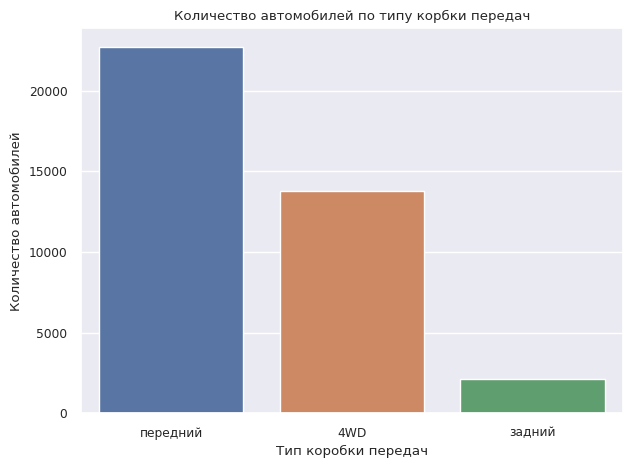

In [18]:
fig = plt.figure(figsize=(7, 5))

sns.barplot(data=df.drive_mode.value_counts().reset_index(), x='index', y='drive_mode')
plt.title('Количество автомобилей по типу корбки передач')
plt.xlabel('Тип коробки передач')
plt.ylabel('Количество автомобилей')
pass

Видим стандартную ситуацию, большинство машин на рынке имеют передний привод, сильно меньше машин полный и совсем малая доля задний

## Цена

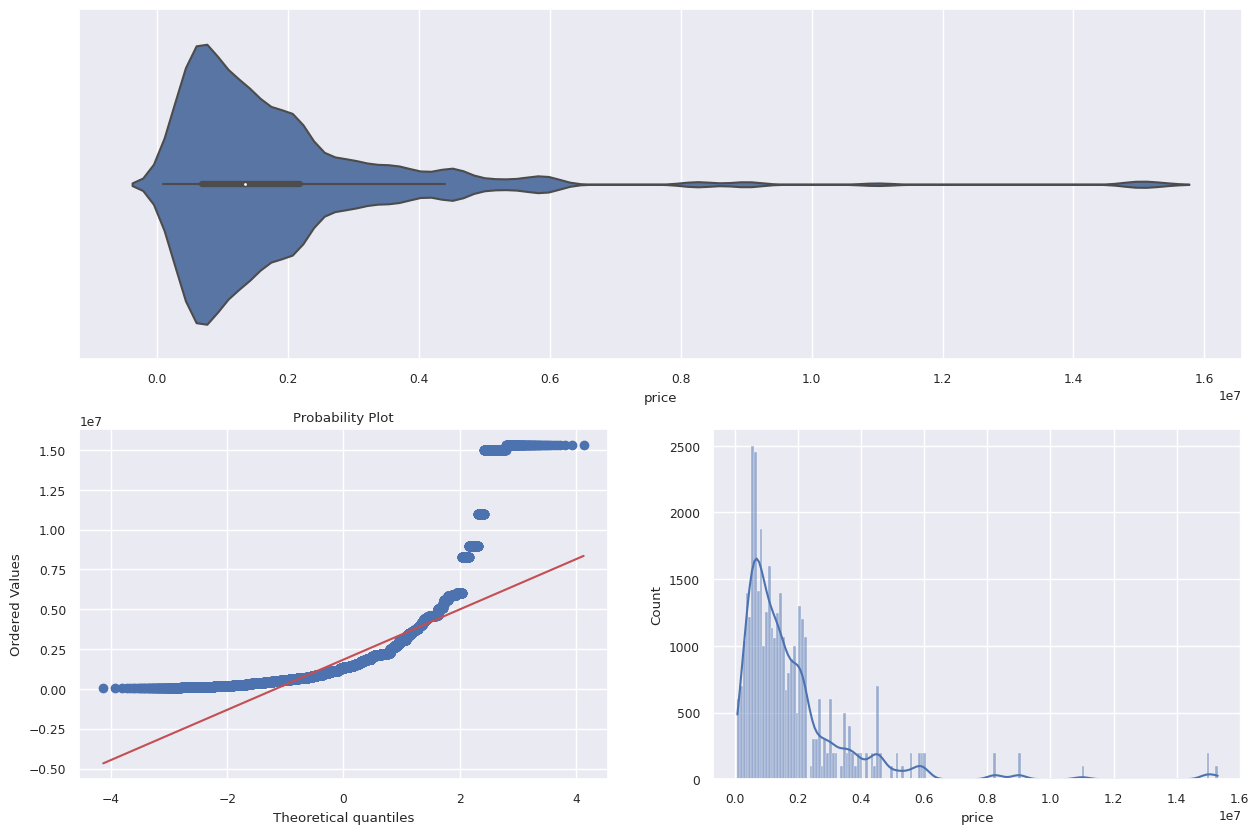

In [19]:
graph('price')

Целевая метка распределена экспоненциально. Нет ничего критичного, не стоит её как-то преобразовывать.

## Пробег

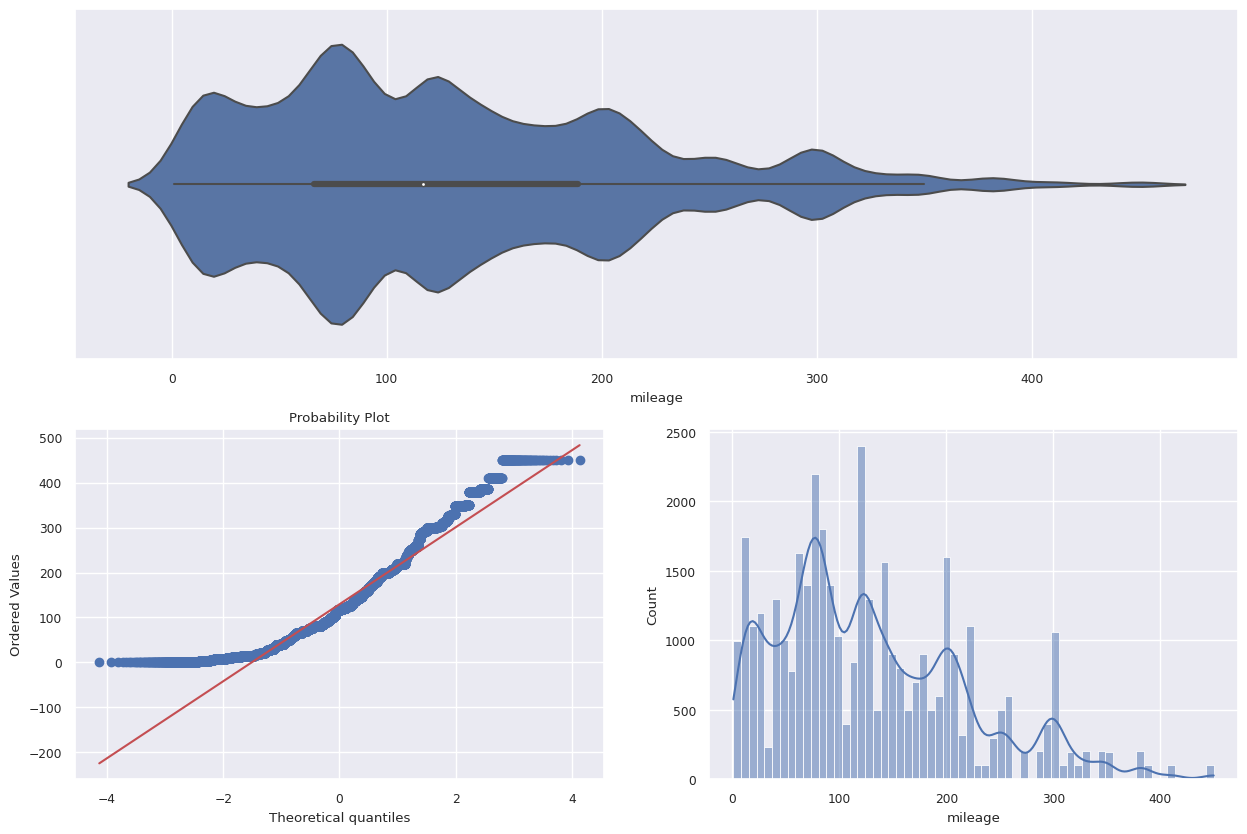

In [20]:
graph('mileage')

Распределение +- похоже на нормальное со сдвигом влево, так как машин с небольшим и средним пробегом явно больше. Мы исследуем актуальные объявления.

## Корреляция

In [21]:
df = pd.get_dummies(df, columns=['make', 'fuel_type', 'transmission', 
                            'drive_mode',])

<Figure size 1400x800 with 0 Axes>

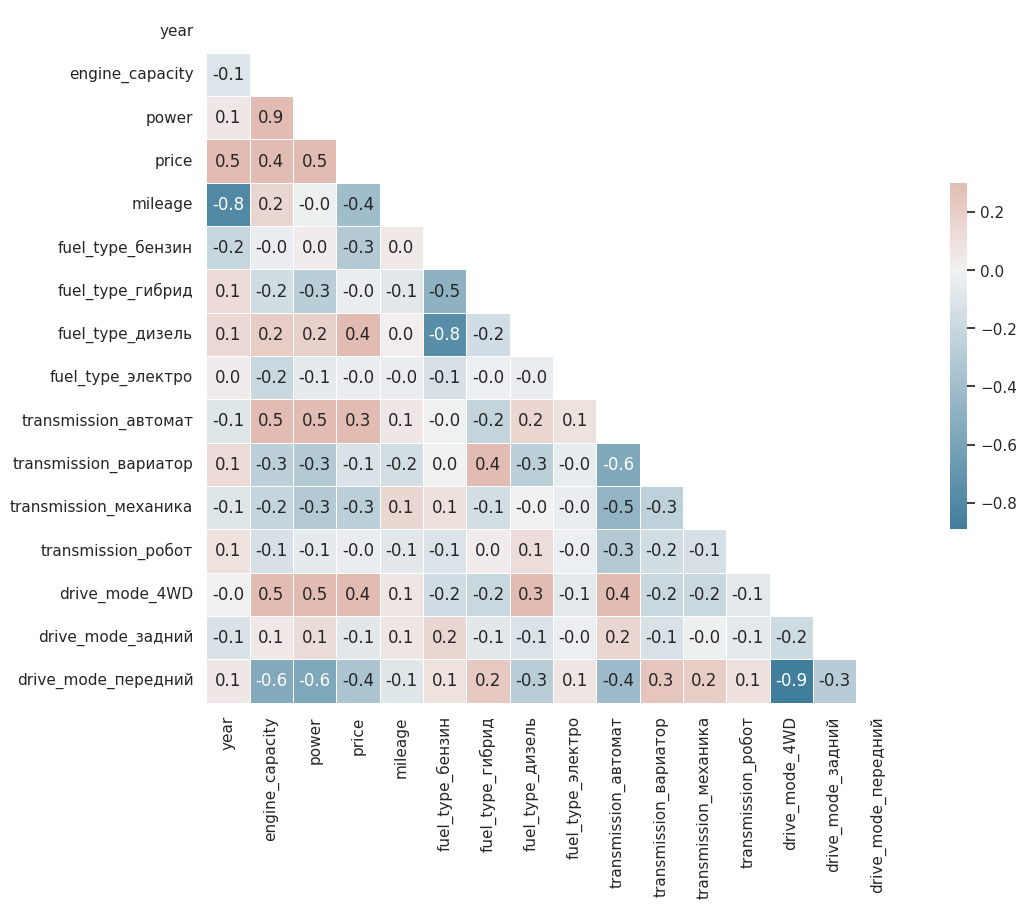

In [30]:
fig = plt.figure(figsize=(14, 8))
sns.set_theme(style="white")

corr = df[[s for s in df.columns if 'make' not in s]].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(13, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".1f")
pass

На корреляционной матрице видим, что наши переменные, а особенно категориальные умеренно коррелируют с целевой меткой. Также можно заметить, что цена имеет линейную зависимость с пробегом, это один из решающих факторов при формировании цены автомобиля.

Важно понимать, что хорошей корреляцией считается высокая корреляция по модулю. Так как нам нужно предугадывать значение, нам не так важно какая будет линейная зависимость. Главное, чтобы она была умеренной или выше.

# Нормализация

In [23]:
X = df.drop(columns=['price'])
y = df.price

In [24]:
scaler = Normalizer()

X = scaler.fit_transform(X)

# Создание модели

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rst)

In [26]:
%%time
model = GradientBoostingRegressor(n_estimators=100, max_depth=10, criterion='squared_error', loss='absolute_error', random_state=rst).fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f'MAE: {mean_absolute_error(y_test, y_pred)}',
      f'MSE: {mean_squared_error(y_test, y_pred)}',
      f'R^2: {r2_score(y_test, y_pred)}', sep='\n')

MAE: 77734.26299239392
MSE: 465807097526.1006
R^2: 0.8770273202520998
CPU times: user 15 s, sys: 30.3 ms, total: 15.1 s
Wall time: 18.5 s


In [27]:
%%time
model = ExtraTreesRegressor(n_estimators=100, max_depth=10, criterion='squared_error', random_state=rst).fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f'MAE: {mean_absolute_error(y_test, y_pred)}',
      f'MSE: {mean_squared_error(y_test, y_pred)}',
      f'R^2: {r2_score(y_test, y_pred)}', sep='\n')

MAE: 57227.824666601395
MSE: 6122883370.838007
R^2: 0.9983835639690878
CPU times: user 6.69 s, sys: 16.4 ms, total: 6.71 s
Wall time: 6.87 s


In [28]:
%%time
model = RandomForestRegressor(n_estimators=100, max_depth=10, criterion='squared_error', max_features='sqrt', random_state=rst).fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f'MAE: {mean_absolute_error(y_test, y_pred)}',
      f'MSE: {mean_squared_error(y_test, y_pred)}',
      f'R^2: {r2_score(y_test, y_pred)}', sep='\n')

MAE: 119301.57561218017
MSE: 26407455541.64875
R^2: 0.9930284540735275
CPU times: user 2.34 s, sys: 5.38 ms, total: 2.34 s
Wall time: 4.08 s


В итоге лучшая модель - ExtraTreesRegressor с параметрами, которые по идее должны удовлетворять нашему исследованию, модель ошибается всего на 57 тысяч, условно в пределах разумного торга, очень хороший показатель

# Вывод

В ходе исследования: 
- выявили некоторые закономерности в данных
- исследовали основные характеристики автомобилей
- выяснили какие переменные линейно влияют на целевую метку
- обучили модель на подходящих параметрах
- получили очень хорошо работающую модель